In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [2]:
from hyperopt.pyll import scope as ho_scope
from hyperopt import fmin, tpe, hp
import tqdm 

### Loading data

In [3]:
import sys
sys.path.insert(0, '../problem2')

In [5]:
from common import get_data, get_freq_data

In [6]:
X, y = get_data('./data/na62_11_pulses.txt', is_one_signal=True)

In [13]:
X = X[:, :370]

### Defining pipelines

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [15]:
TIME_SCALE_COEF = 0.2

In [16]:
# freq_values = [1, 10, 20, 30, 40, 50]
freq_values = [1]

In [17]:
def print_results(iter_num=200):
    global X_freq
    for freq in freq_values:
        X_freq = get_freq_data(X, freq=freq)

        best = fmin(
            fn=f,  # "Loss" function to minimize
            space=space,  # Hyperparameter space
            algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
            max_evals=iter_num  # Perform 100 trials
        )

        print('-----------------------------------------------------')
        print("Freq:", freq)
        print("X_freq shape:", X_freq.shape)
        print("Found minimum after %d trials:" %(iter_num))
        print(best)
        print('-----------------------------------------------------')

### Huber regressor

In [18]:
def f(space):
    huber_reg = HuberRegressor(epsilon=space['epsilon'], max_iter=space['max_iter'], alpha=space['alpha'])
    scores = cross_validate(huber_reg, X_freq, y, scoring='neg_mean_absolute_error', cv=5)
    return TIME_SCALE_COEF * -scores['test_score'].mean()
    
space = {
    'epsilon':  hp.loguniform('epsilon', low=np.log(1.1), high=np.log(10)),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=100, high=500, q=10)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.0001), high=np.log(0.01)),
}

global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [04:10<00:00,  5.01s/it, best loss: 0.10524695266405254]
-----------------------------------------------------
Freq: 1
X_freq shape: (1207, 370)
Found minimum after 50 trials:
{'alpha': 0.0006936700770729473, 'epsilon': 1.6447564875032097, 'max_iter': 430.0}
-----------------------------------------------------


### Ridge regressor

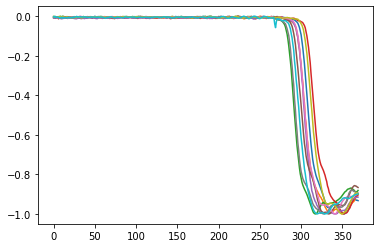

In [22]:
for i in range(10):
    plt.plot(X[i])

In [23]:
def f(space):
    ridge_reg = linear_model.Ridge(solver=space['solver'], max_iter=space['max_iter'], alpha=space['alpha'])
    scores = cross_validate(ridge_reg, X_freq, y, scoring='neg_mean_absolute_error', cv=5)
    return TIME_SCALE_COEF * -scores['test_score'].mean()
    
space = {
    'solver': hp.choice('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=1000, high=5000, q=100)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.0001), high=np.log(1)),
}

global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [01:12<00:00,  1.45s/it, best loss: 0.10503333601959056]
-----------------------------------------------------
Freq: 1
X_freq shape: (1207, 370)
Found minimum after 50 trials:
{'alpha': 0.10704394865042775, 'max_iter': 4900.0, 'solver': 0}
-----------------------------------------------------


### Lasso regressor

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
def f(space):
    lasso_reg = linear_model.Lasso(max_iter=space['max_iter'], alpha=space['alpha'], normalize=space['normalize'])
    scores = cross_validate(lasso_reg, X_freq, y, scoring='neg_mean_absolute_error', cv=5)
    return TIME_SCALE_COEF * -scores['test_score'].mean()
    
space = {
    'normalize': hp.choice('normalize', [True, False]),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=1000, high=5000, q=100)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.0001), high=np.log(1)),
}

global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [01:23<00:00,  1.67s/it, best loss: 0.10569754594495905]
-----------------------------------------------------
Freq: 1
X_freq shape: (1207, 370)
Found minimum after 50 trials:
{'alpha': 0.0010852243110024613, 'max_iter': 3000.0, 'normalize': 0}
-----------------------------------------------------


### Decision tree

In [27]:
def f(space):
    dt_reg = tree.DecisionTreeRegressor(max_depth=space['max_depth'], min_samples_split=space['min_samples_split'],
                                       min_samples_leaf=space['min_samples_leaf'], min_weight_fraction_leaf=
                                        space['min_weight_fraction_leaf'], max_features=space['max_features'])
    scores = cross_validate(dt_reg, X_freq, y, scoring='neg_mean_absolute_error', cv=5)
    return TIME_SCALE_COEF * -scores['test_score'].mean()
    
space = {
    'max_depth':  ho_scope.int(hp.quniform('max_iter', low=4, high=100, q=2)),
    'min_samples_split': ho_scope.int(hp.quniform('min_samples_split', low=2, high=10, q=1)),
    'min_samples_leaf':  ho_scope.int(hp.quniform('min_samples_leaf', low=1, high=10, q=1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2'])
}

global X_freq
print_results(iter_num=100)

100%|██████████| 100/100 [00:22<00:00,  4.45it/s, best loss: 0.10059889405263314]
-----------------------------------------------------
Freq: 1
X_freq shape: (1207, 370)
Found minimum after 100 trials:
{'max_features': 0, 'max_iter': 26.0, 'min_samples_leaf': 6.0, 'min_samples_split': 8.0, 'min_weight_fraction_leaf': 0.0102039874421182}
-----------------------------------------------------


### Passive aggressive

In [28]:
def f(space):
    pa_reg = PassiveAggressiveRegressor(max_iter=space['max_iter'], tol=space['max_iter'], 
                                       C = space['C'])
    scores = cross_validate(pa_reg, X_freq, y, scoring='neg_mean_absolute_error', cv=5)
    return TIME_SCALE_COEF * -scores['test_score'].mean()
    
space = {
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=1000, high=5000, q=100)),
    'tol': hp.loguniform('tol', low=np.log(0.000001), high=np.log(0.001)),
    'verbose': ho_scope.int(hp.quniform('verbose', low=1, high=100, q=2)),
    'C':  hp.loguniform('C', low=np.log(0.0001), high=np.log(10)),
}

global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [00:03<00:00, 15.62it/s, best loss: 0.4796799836052835] 
-----------------------------------------------------
Freq: 1
X_freq shape: (1207, 370)
Found minimum after 50 trials:
{'C': 0.23093357092839936, 'max_iter': 4800.0, 'tol': 0.00010713753581551084, 'verbose': 16.0}
-----------------------------------------------------


### Xgboost

In [29]:
def f(space):
    xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster=space['booster'], eta=space['eta'], 
                               gamma=space['gamma'], max_depth=space['max_depth'], reg_lambda=space['lambda'],
                               alpha=space['alpha'], verbosity=0)
    scores = cross_validate(xgb_reg, X_freq, y, scoring='neg_mean_absolute_error', cv=5)
    return TIME_SCALE_COEF * -scores['test_score'].mean()
    
space = {
    'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'eta': hp.loguniform('eta', low=np.log(0.001), high=np.log(1)),
    'gamma': hp.loguniform('gamma', low=np.log(0.001), high=np.log(100)),
    'max_depth': ho_scope.int(hp.quniform('max_depth', low=5, high=50, q=2)),
    'lambda': hp.loguniform('lambda', low=np.log(0.001), high=np.log(10)),
    'alpha':  hp.loguniform('alpha', low=np.log(0.001), high=np.log(10)),
}

global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [34:58<00:00, 41.96s/it, best loss: 0.07631883886631681]
-----------------------------------------------------
Freq: 1
X_freq shape: (1207, 370)
Found minimum after 50 trials:
{'alpha': 9.720814421482372, 'booster': 0, 'eta': 0.040967242033212566, 'gamma': 0.11403358374490781, 'lambda': 0.0010412564895330462, 'max_depth': 42.0}
-----------------------------------------------------


In [30]:
xgb_reg = xgb.XGBRegressor(objective="reg:linear", booster='gbtree', eta=0.040967242033212566, 
                               gamma=0.11403358374490781, max_depth=42, reg_lambda=0.0010412564895330462,
                               alpha=9.720814421482372, verbosity=0)

In [31]:
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
scores = cross_validate(xgb_reg, X, y, scoring=scoring, cv=5)

print("95% confidence interval:")
print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

95% confidence interval:
r2_score: 0.99823 (+/- 0.00129)
MSE[ns^2]: 0.01211 (+/- 0.04539)
RMSE[ns]: 0.10846 (+/- 0.03727)
MAE[ns]: 0.07632 (+/- 0.00756)
